In [1]:
import pandas as pd
import gc

from itertools import product
import pandas as pd
import numpy as np
from tqdm import  tqdm
from sklearn.metrics import mean_squared_error
import geobleu
from tqdm import tqdm
from pandarallel import pandarallel
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

pandarallel.initialize(progress_bar=True, use_memory_fs = False, nb_workers=4)
tqdm.pandas()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_parquet("/workspace/resources/input/task1_dataset_raw_train.parquet")

In [3]:
test_uids = df.loc[df["x"] == 999, "uid"].unique()
df = df[~df["uid"].isin(test_uids)].reset_index(drop=True)
uids = df["uid"].unique()
df = df[df["uid"].isin(uids[:10000])]

In [4]:
tr_uids = uids[:5000]
va_uids = uids[5000:]

train_df = df[df["uid"].isin(tr_uids)].reset_index(drop=True)
valid_df = df[df["uid"].isin(va_uids)].reset_index(drop=True)

In [5]:
def assign_day_of_week(df):
    df["dayofweek"] = (df["d"] % 7).astype(int)
    df["weekend"] = df["dayofweek"].isin([6, 0])
    return df


def assign_t_labe(df):
    morning = {k: 0 for k in list(range(12, 36))}
    midnight = {k: 1 for k in list(range(36, 48)) + list(range(0, 12))}
    t_label_mapping = {**morning, **midnight}
    df["t_label"] = df["t"].map(t_label_mapping)
    return df

def assign_detailed_t_label(df):
    division = 48 // 12  # 48を12で割った値
    result_dict = {i: i // division for i in range(48)}
    df["detailed_t_label"] = df["t"].map(result_dict)
    return df
    

train_df = assign_day_of_week(train_df)
train_df = assign_t_labe(train_df)
train_df = assign_detailed_t_label(train_df)

valid_df = assign_day_of_week(valid_df)
valid_df = assign_t_labe(valid_df)
valid_df = assign_detailed_t_label(valid_df)


In [6]:
train_df

,uid,d,t,x,y,dayofweek,weekend,t_label,detailed_t_label
0,0,0,1,79,86,0,True,1,0
1,0,0,2,79,86,0,True,1,0
2,0,0,8,77,86,0,True,1,2
3,0,0,9,77,86,0,True,1,2
4,0,0,19,81,89,0,True,0,4
...,...,...,...,...,...,...,...,...,...
69073,49,73,42,166,58,3,False,1,10
69074,49,74,19,164,59,4,False,0,4
69075,49,74,24,165,59,4,False,0,6
69076,49,74,26,166,58,4,False,0,6


In [7]:
class CycleImputer:
    def __init__(self, group_keys=["uid", "dayofweek", "t"], agg_method="median",):
        self.group_keys=group_keys
        self.agg_method = agg_method
        
        self.agg_df = None
        self.base_df = None
        self.agg_cols = [f"x_{agg_method}", f"y_{agg_method}"]
    
    def aggregate(self, df, d=60):
        self.agg_df  = df[df["d"] < d].reset_index(drop=True).groupby(self.group_keys)[["x", "y"]].agg([self.agg_method])
        self.agg_df.columns = [f"{x[0]}_{x[1]}" for x in self.agg_df .columns]
        self.agg_df.reset_index(inplace=True)
    
    def make_base(self, df):
        lists = [df[x].unique() for x in self.group_keys]
        self.base_df = self.create_combinations_df(lists, columns=self.group_keys)
        
        if self.agg_df is None:
            self.aggregate(df)
            
        self.base_df = pd.merge(self.base_df, self.agg_df, on=self.group_keys, how="left")
        self.base_df = self.base_df.sort_values(self.group_keys).reset_index(drop=True)


    def impute(self, df, cycle_group=["uid", "dayofweek"], T=2):
        # TODO: to bidirectional 
        
        if self.base_df is None:
            self.make_base(df)
            
        fill_missing = lambda x : self.fill_missing(group=x, T=T)
        df_filled = self.base_df.groupby(cycle_group, sort=False).parallel_apply(fill_missing).reset_index(drop=True)
        
        # 各uidの平均を計算
        uid_means = self.base_df.groupby('uid')[[f'x_{self.agg_method}', f'y_{self.agg_method}']].mean()

        # uidをインデックスとしてセット
        df_filled.set_index('uid', inplace=True)

        # 残った欠損値を各uidの平均で埋める
        df_filled[f'x_{self.agg_method}'].fillna(uid_means[f'x_{self.agg_method}'], inplace=True)
        df_filled[f'y_{self.agg_method}'].fillna(uid_means[f'y_{self.agg_method}'], inplace=True) 
        
        assert df_filled[f'x_{self.agg_method}'].isnull().sum() == 0
        return df_filled.reset_index()
        
    
    def fill_missing(self, group, T=2):
        # T期以内の連続の欠損をt-1期の値で埋める
        group_filled = group.copy()
        for col in [f'x_{self.agg_method}', f'y_{self.agg_method}']:
            missing_streak = 0
            for i in range(1, len(group_filled)):
                if pd.isna(group_filled[col].iloc[i]):
                    missing_streak += 1
                    if missing_streak <= T:
                        group_filled.loc[group_filled.index[i], col] = group_filled[col].iloc[i-1]
                else:
                    missing_streak = 0
        return group_filled
        
    
    @staticmethod   
    def create_combinations_df(lists, columns):
        """
        与えられた複数のリストのすべての組み合わせを持つDataFrameを作成する関数
        
        Parameters:
        lists : リストのリスト
            各リストは、組み合わせを作成するための要素を含む
        columns : list
            DataFrameのカラム名を指定するリスト
        
        Returns:
        df : DataFrame
            すべての組み合わせを持つDataFrame
        """
        
        if len(lists) != len(columns):
            raise ValueError("The number of lists must match the number of columns")
        
        combinations = list(product(*lists))
        
        df = pd.DataFrame(combinations, columns=columns)
        return df

imputer = CycleImputer(group_keys=["uid", "dayofweek", "t"], agg_method="median")
df_filled = imputer.impute(df=train_df, cycle_group=["uid", "dayofweek"], T=8)
        

In [8]:
preds_df = train_df.query("d >= 60").dropna().reset_index(drop=True)
preds_df = pd.merge(preds_df, df_filled, on=imputer.group_keys, how="left")
preds_df

,uid,d,t,x,y,dayofweek,weekend,t_label,detailed_t_label,x_median,y_median
0,0,60,12,84,88,4,False,0,3,81.0,91.0
1,0,60,13,96,70,4,False,0,3,83.0,92.0
2,0,60,14,115,78,4,False,0,3,84.5,93.5
3,0,60,15,114,78,4,False,0,3,84.0,92.0
4,0,60,19,114,78,4,False,0,4,85.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...
13721,49,73,42,166,58,3,False,1,10,167.0,58.0
13722,49,74,19,164,59,4,False,0,4,184.0,51.0
13723,49,74,24,165,59,4,False,0,6,169.0,57.0
13724,49,74,26,166,58,4,False,0,6,185.0,61.0


In [9]:

reference = preds_df[["uid", "d", "t", "x", "y"]]
generated = preds_df[["uid", "d", "t"] + imputer.agg_cols]
generated.columns = reference.columns

In [10]:
geobleu_score = 0
dtw_score = 0

eval_uids = reference["uid"].unique()[:100]
for uid in tqdm(eval_uids):
    a_generated = generated.loc[generated["uid"] == uid, ["d", "t", "x", "y"]].values.tolist()
    a_reference = reference.loc[reference["uid"] == uid, ["d", "t", "x", "y"]].values.tolist()
    
    geobleu_score += geobleu.calc_geobleu(a_generated, a_reference, processes=3)
    dtw_score += geobleu.calc_dtw(a_generated, a_reference, processes=3)

geobleu_score = geobleu_score / len(eval_uids)
dtw_score = dtw_score / len(eval_uids)

print(f"geobleu_score={geobleu_score}, dtw_score={dtw_score}")

rmse = mean_squared_error(y_true=reference[["x", "y"]].values, y_pred=generated[["x", "y"]].values, squared=False)
print(f"rmse={rmse}")

100%|██████████| 50/50 [00:07<00:00,  6.38it/s]

geobleu_score=0.2658067069339079, dtw_score=54.174355647601544
rmse=15.156218888521739


In [11]:
train_df_with_agg = pd.merge(train_df, df_filled, on=imputer.group_keys, how="left")
train_df_with_agg = train_df_with_agg.rename(columns={imputer.agg_cols[0]:"agg_x", imputer.agg_cols[1]:"agg_y"})

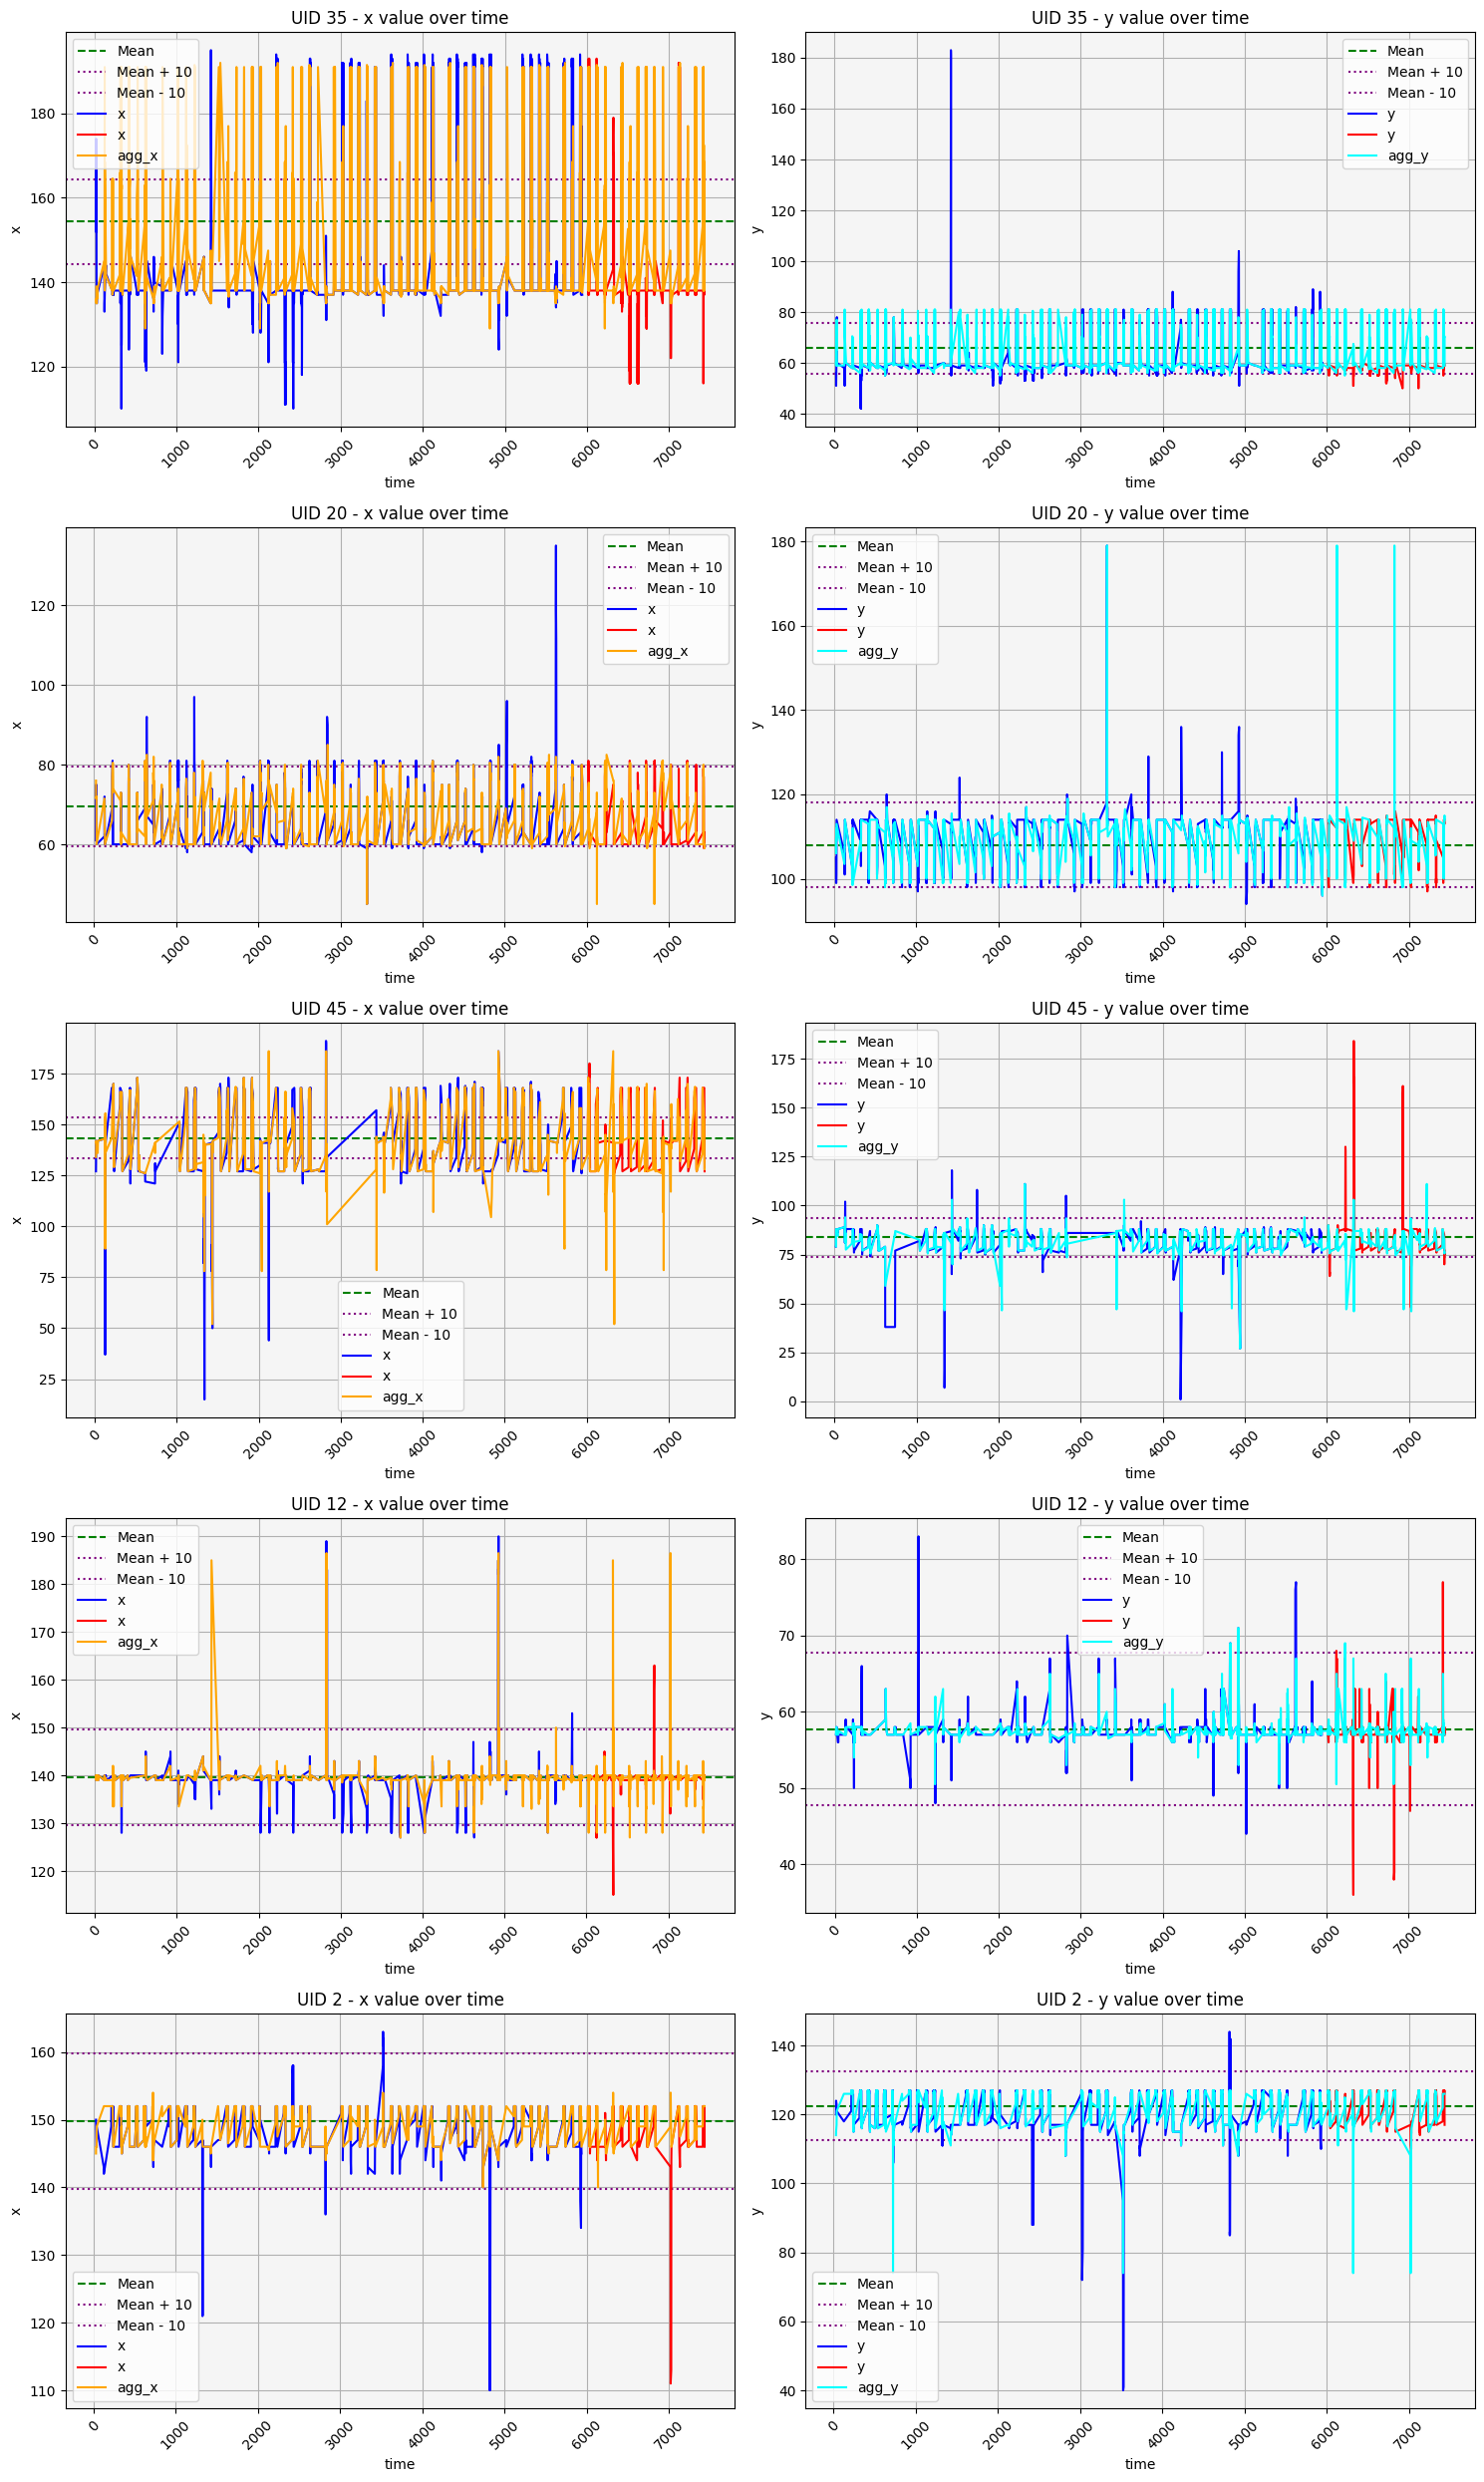

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_uid(df, uids):
    """
    df: DataFrame - 入力データ
    uids: list - グラフを出力したいuidのリスト
    """
        
    # d >= 60 の部分の色を変えるための列
    df['color_condition'] = df['d'] >= 60

    n_uids = len(uids)
    fig, axs = plt.subplots(n_uids, 2, figsize=(15, 5*n_uids))

    for i, uid in enumerate(uids):
        df_uid = df[df['uid'] == uid]

        for j, col in enumerate(['x', 'y']):
            mean_val = df_uid[col].mean()
            
            # 平均値の線
            axs[i, j].axhline(mean_val, color='green', linestyle='--', label='Mean')
            
            # 平均値±10の線
            axs[i, j].axhline(mean_val + 10, color='purple', linestyle=':', label='Mean + 10')
            axs[i, j].axhline(mean_val - 10, color='purple', linestyle=':', label='Mean - 10')
            
            sns.lineplot(x='time', y=col, hue='color_condition', data=df_uid, palette=["blue", "red"], ax=axs[i, j], legend=False, label=col)
            
            # agg_x または agg_y のデータを追加
            if col == 'x':
                sns.lineplot(x='time', y='agg_x', data=df_uid, color='orange', ax=axs[i, j], label='agg_x')
            else:
                sns.lineplot(x='time', y='agg_y', data=df_uid, color='cyan', ax=axs[i, j], label='agg_y')
            
            axs[i, j].set_title(f'UID {uid} - {col} value over time')
            axs[i, j].tick_params(axis='x', rotation=45)
            axs[i, j].grid(True)
            axs[i, j].set_facecolor("#f5f5f5")
            axs[i, j].legend()
    
    plt.tight_layout()
    plt.show()

train_df_with_agg["time"] = (train_df_with_agg["d"].astype(str).str.zfill(2) + train_df_with_agg["t"].astype(str).str.zfill(2)).astype(int)

uids = pd.Series(train_df["uid"].unique()).sample(5, random_state=None)
plot_uid(train_df_with_agg, uids)
